# Evaluating the LLM Models
Mahan Madani - Mohammad Mehdi Begmaz

## Load basic libraries and models

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, roc_curve

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer)

In [5]:
df = pd.read_csv("./dataset/BG3_reviews_updated.csv")  # load the full version of the dataset
df['review'] = df['review'].astype(str)
df['word_count'] = df['review'].apply(lambda text: len(text.split()))

df = df[df['word_count'] > 10]
df = df[['review', 'voted_up']].dropna().reset_index(drop=True)

print(df.columns)
print(df.shape)

Index(['review', 'voted_up'], dtype='object')
(161390, 2)


In [6]:
negative_df = df[df['voted_up'] == 0].reset_index(drop=True)
print(negative_df.shape)

(8589, 2)


In [7]:
positive_df = df[df['voted_up'] == 1].reset_index(drop=True)
print(positive_df.shape)

(152801, 2)


In [8]:
from transformers.utils import logging
import transformers

logging.set_verbosity(transformers.logging.ERROR)

In [9]:
classification_model_v1 = AutoModelForSequenceClassification.from_pretrained("./model/classification_v1")
tokenizer_v1 = AutoTokenizer.from_pretrained("./model/classification_v1")

In [10]:
classification_model_v2 = AutoModelForSequenceClassification.from_pretrained("./model/classification_v2")
tokenizer_v2 = AutoTokenizer.from_pretrained("./model/classification_v2")

## Evaluating the text classification models

### Evaluation using  accuracy

In [11]:
import re

def clean_text(text):
    cleaned_text = text.lower().replace('\n', ' ')
    cleaned_text = re.sub('\[.*?\]', '', cleaned_text)
    cleaned_text = re.sub('[^a-zA-Z0-9()/!?&\'",. ]', '', cleaned_text)

    if len(cleaned_text) > 1024:
        cleaned_text = cleaned_text[:1024]

    return cleaned_text

In [12]:
def classify(model, tokenizer, text_list):
    predictions = []
    for text in text_list:
        text = clean_text(text)
        inputs = tokenizer.encode(text, return_tensors="pt")
        # print(text)
        logits = model(inputs).logits
        prediction = torch.argmax(logits)
        
        predictions.append(prediction.tolist())

    return predictions

In [13]:
def test_model(model, tokenizer, x_test, y_test):
    y_pred = classify(model, tokenizer, x_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy: >.6}")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=[4,4])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='crest', cbar=False, linewidths=1,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])

    plt.title('Confusion Matrix')

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1: >.6}")


In [14]:
sample_df = pd.concat([negative_df.sample(n=100, random_state=7), positive_df.sample(n=100, random_state=7)]).reset_index(drop=True)

Accuracy: 0.935
F1 Score: 0.934673


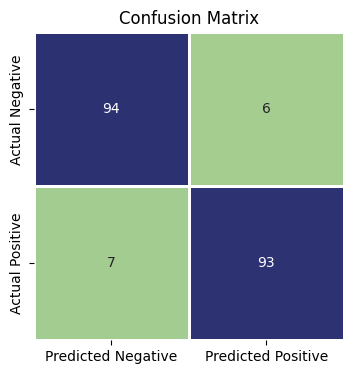

In [15]:
test_model(classification_model_v2, tokenizer_v2, sample_df['review'], sample_df['voted_up'])